In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.lib.io import file_io

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import losses
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.preprocessing import image_dataset

from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils, cv2, dlib

%matplotlib inline

In [ ]:
EPOCHS = 150
BS = 128
DROPOUT_RATE = 0.3
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=(48,48,3)))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(48,48,3),name="conv1"))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool1"))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same',name="conv2"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool2"))         
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name="conv3"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool3"))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name="conv4"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool4"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1024, activation='relu',name='fc1'))
model.add(Dropout(DROPOUT_RATE))
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax',name='fcsoftmax'))

sgd = SGD(lr=SGD_LEARNING_RATE,momentum=0.9, decay=SGD_DECAY, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=['accuracy'])

# checkpoint
cp_filepath='./model/Baseline-weights-best.hdf5'
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
checkpoint = ModelCheckpoint(cp_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [rlrop,checkpoint]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 48, 48, 3)         12        
_________________________________________________________________
conv1 (Conv2D)               (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 24, 24, 32)        0

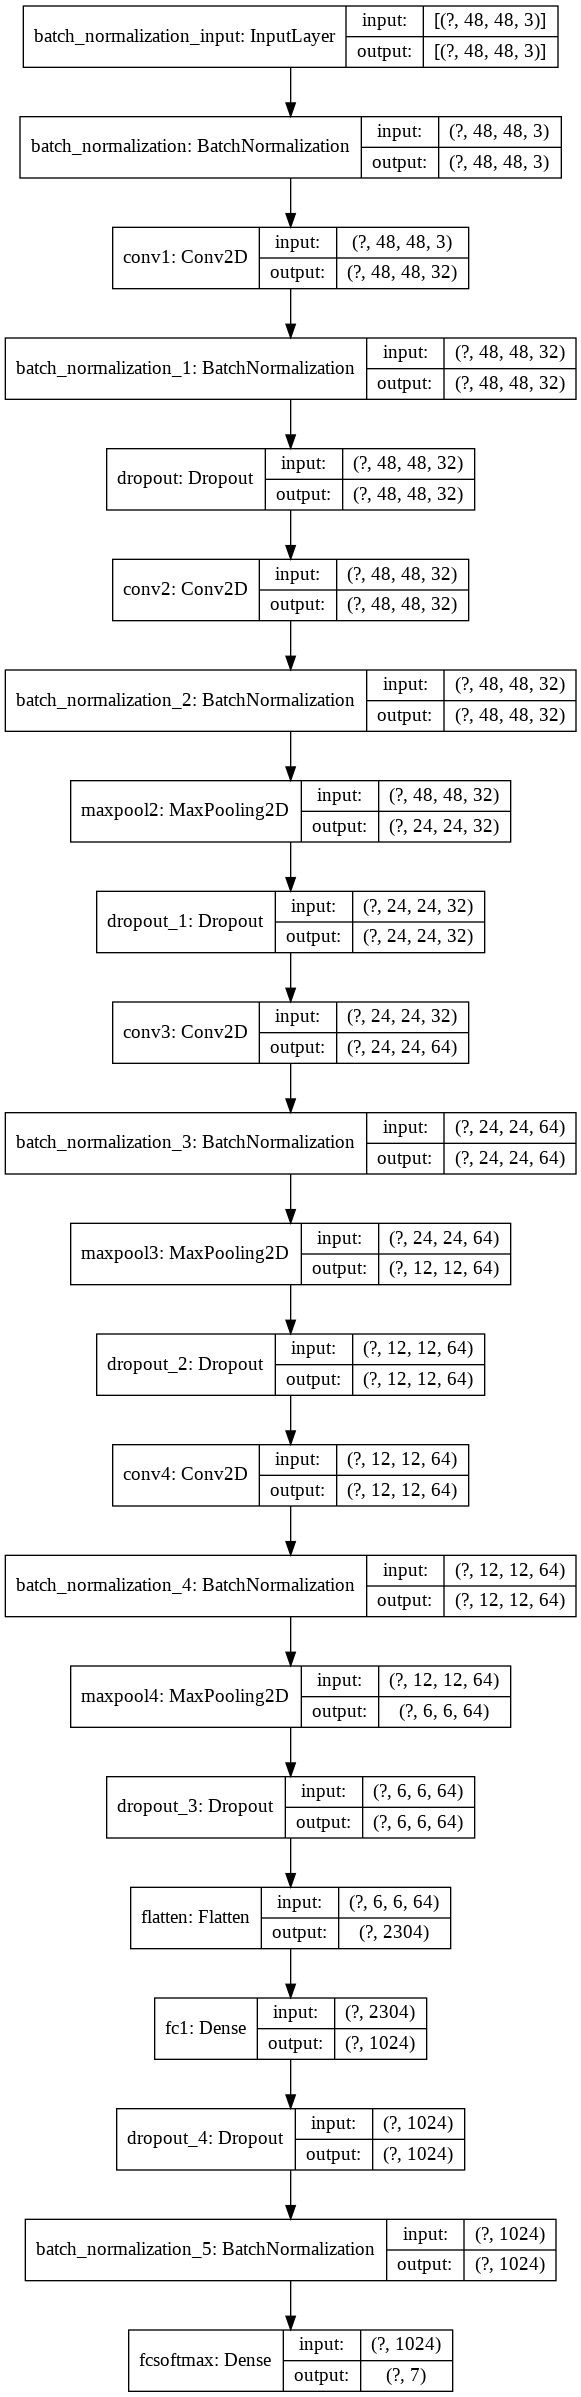

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
%%bash
root='./../dataset/train/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

angry:     3995
disgust:      436
fear:     4097
happy:     7215
neutral:     4965
sad:     4830
surprise:     3171


In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
fa = FaceAligner(predictor, desiredLeftEye=(0.3,0.3), desiredFaceWidth=48)

In [ ]:
def preprocessing(path, filename):
    image = cv2.imread(path)
    image = imutils.resize(image, width=800)
    face = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    gray_face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    rect = detector(face, 1)
    if (len(rect) > 0):
        rect = rect[0]
        face_aligned = fa.align(face, gray_face, rect)
        cv2.imwrite(filename, face_aligned)

In [ ]:
source = './../dataset'
target = './../dataset2'
for dataset in os.listdir(source):
    dataset_dir = source+'/'+dataset
    if os.path.isdir(dataset_dir):
        for category in os.listdir(dataset_dir):
            category_dir = dataset_dir+'/'+category
            if os.path.isdir(category_dir):
                for file in os.listdir(category_dir):
                    path = category_dir+'/'+file
                    filename = target+'/'+dataset+'/'+category+'/'+file
                    if os.path.isfile(path) and not os.path.exists(filename+'.jpg'):
                        preprocessing(path, filename)
                print("Finish preprocessing {} in {}...".format(category, dataset))
print("Finish preprocessing!")

Finish preprocessing happy in test...
Finish preprocessing sad in test...
Finish preprocessing fear in test...
Finish preprocessing surprise in test...
Finish preprocessing neutral in test...
Finish preprocessing angry in test...
Finish preprocessing disgust in test...
Finish preprocessing happy in train...
Finish preprocessing sad in train...
Finish preprocessing fear in train...
Finish preprocessing surprise in train...
Finish preprocessing neutral in train...
Finish preprocessing angry in train...
Finish preprocessing disgust in train...
Finish preprocessing!


In [ ]:
def load_data(train_path, test_path):
    train_data = image_dataset.image_dataset_from_directory(
            train_path, 
            label_mode='categorical',
            batch_size=BS,
            image_size=(48, 48), 
            shuffle=True, 
            seed=1337,
            validation_split=0.2,
            subset="training")
    val_data = image_dataset.image_dataset_from_directory(
            train_path, 
            label_mode='categorical',
            batch_size=BS,
            image_size=(48, 48), 
            shuffle=True, 
            seed=1337,
            validation_split=0.2,
            subset="validation")
    test_data = image_dataset.image_dataset_from_directory(
            test_path, 
            label_mode='categorical',
            batch_size=BS,
            image_size=(48, 48), 
            shuffle=True)
    return train_data, val_data, test_data

In [ ]:
train_ds, val_ds, test_ds = load_data(target+'/train', target+'/test')
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 22035 files belonging to 7 classes.
Using 17628 files for training.
Found 22035 files belonging to 7 classes.
Using 4407 files for validation.
Found 5512 files belonging to 7 classes.


In [ ]:
train_ds.take(1)

<TakeDataset shapes: ((None, 48, 48, 3), (None, 7)), types: (tf.float32, tf.float32)>

In [ ]:
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    shuffle=True, 
    epochs=EPOCHS,
    callbacks=callbacks_list,
    use_multiprocessing=False,)

ve from 0.66644
138/138 [==============================] - 72s 520ms/step - loss: 0.0731 - accuracy: 0.9769 - val_loss: 1.5696 - val_accuracy: 0.6649
Epoch 84/150
138/138 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.9767
Epoch 00084: val_accuracy did not improve from 0.66644
138/138 [==============================] - 72s 523ms/step - loss: 0.0711 - accuracy: 0.9767 - val_loss: 1.5679 - val_accuracy: 0.6621
Epoch 85/150
138/138 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9757
Epoch 00085: val_accuracy did not improve from 0.66644
138/138 [==============================] - 72s 520ms/step - loss: 0.0754 - accuracy: 0.9757 - val_loss: 1.5475 - val_accuracy: 0.6630
Epoch 86/150
138/138 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9754
Epoch 00086: val_accuracy did not improve from 0.66644
138/138 [==============================] - 73s 526ms/step - loss: 0.0755 - accuracy: 0.9754 - val_loss: 1.5568 - val_accura

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


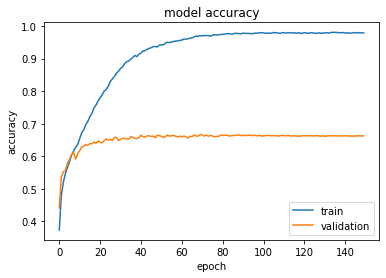

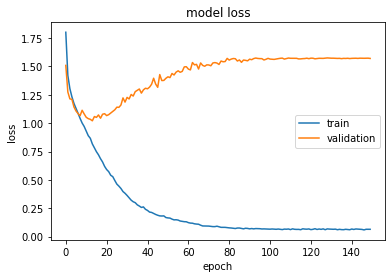

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.savefig('./../results/baseline' + epoch_str + dropout_str + '-accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.savefig('./../results/baseline' + epoch_str + dropout_str + '-loss.png')
plt.show()

In [ ]:
print('\n# Evaluate on validation data')
results_val = model.evaluate(val_ds, batch_size=BS)
print('validation loss, validation accuracy:', results_val)


# Evaluate on validation data
35/35 [==============================] - 3s 97ms/step - loss: 1.5704 - accuracy: 0.6626
validation loss, validation accuracy: [1.5703985691070557, 0.662582278251648]


In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate(test_ds, batch_size=BS)
print('test loss, test accuracy:', results_test)


# Evaluate on test data
44/44 [==============================] - 5s 120ms/step - loss: 1.5137 - accuracy: 0.6751
test loss, test accuracy: [1.5137064456939697, 0.6750725507736206]


In [ ]:
test_acc = '-test_acc_%.3f' % results_test[1]
model.save('./baseline' + epoch_str + dropout_str + test_acc + '.h5')